# 集成平均回歸(Ensemble Averaging Regressor)

##### 先引入我們需要的packages

In [1]:
import os 
import numpy as np
import random
import cvxopt
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt

# Training Data

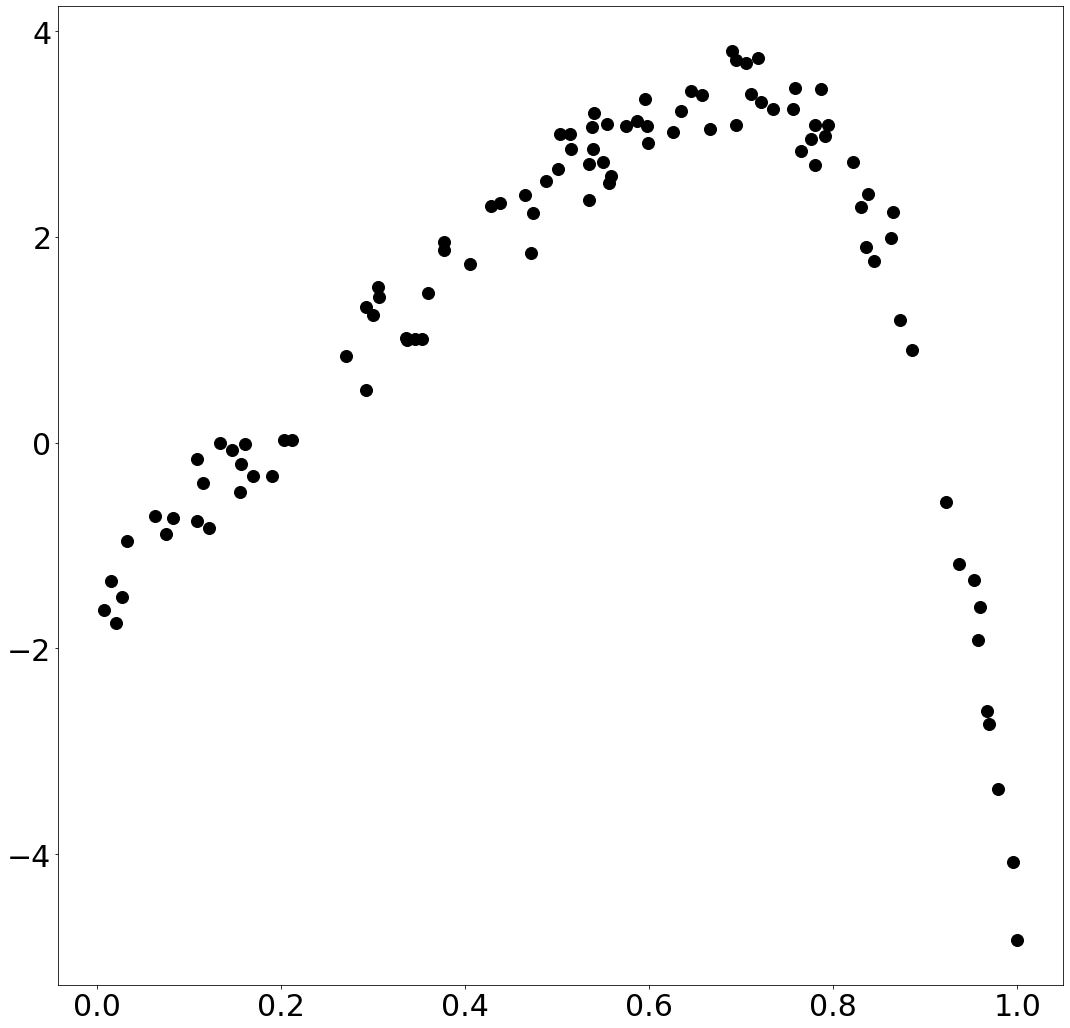

In [2]:
# p0~p9代表0次到9次方
p9,p8,p7,p6,p5,p4,p3,p2,p1,p0=1,-10,3,-8,5,-6,7,-4,9,-2
x=np.zeros(100)
y=np.zeros(100)
# 隨機產生數據點
for i in range(0,len(x)):
    x[i]+=random.random()
    y[i]+=random.random()*1
power=[p9,p8,p7,p6,p5,p4,p3,p2,p1,p0]
for i in range(0,len(power)):
    y+=power[len(power)-i-1]*(x**i)
# 視覺化
plt.rcParams["figure.figsize"] = (18,18)
plt.plot(x,y,"ko",markersize=12)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.show()

# Polynomial Kernel

In [3]:
def Polynomial_kernel(x,xx,power,gamma,zeta):
    return (zeta+gamma*np.outer(x,xx))**power

# Kernel Ridge Regression

In [4]:
def KRR(x,y,lambda_2,c,gamma,zeta,N):    
    K=Polynomial_kernel(x,x,c,gamma,zeta)
    a=np.dot(np.linalg.inv(lambda_2*np.diag(np.ones(N))+K),y)
    return a

# Support Vector Regression

In [5]:
def SVR(x,y,CC,c,gamma,zeta,N):
    t=0.05
    K=Polynomial_kernel(x,x,c,gamma,zeta)
    Q = cvxopt.matrix(np.concatenate([np.concatenate([K,-K],axis=0),np.concatenate([-K,K],axis=0)],axis=1))
    p = cvxopt.matrix(np.concatenate([np.ones(N)*t-y,np.ones(N)*t+y]),(2*N,1))
    G = cvxopt.matrix(np.concatenate([np.diag(np.ones(2*N)* 1.),np.diag(np.ones(2*N)* -1.)]))
    h = cvxopt.matrix(np.concatenate([CC*np.ones(2*N),np.zeros(2*N)]))
    A = cvxopt.matrix(np.concatenate([np.ones(N),-np.ones(N)]),(1,2*N))
    b = cvxopt.matrix(0.0)
    cvxopt.solvers.options['show_progress'] = False
    cvxopt.solvers.options['abstol'] = 1e-10
    cvxopt.solvers.options['reltol'] = 1e-10
    cvxopt.solvers.options['feastol'] = 1e-10
    a=np.array(cvxopt.solvers.qp(Q, p, G, h, A, b)['x']).flatten()
    aa=a[:N]-a[N:2*N]
    for i in range(0,N):
        if(a[i]>10**-6):
            U_SV=i
            break
    for i in range(N,2*N):
        if(a[i]>10**-6):
            D_SV=i
            break
    Com=0
    for i in range(0,N):
        if(abs(aa[i])>1e-6):
            Com+=aa[i]*K[i,U_SV]
    b_U=y[U_SV]-Com
    Com=0
    for i in range(0,N):
        if(abs(aa[i])>1e-6):
            Com+=aa[i]*K[i,D_SV-N]
    b_D=y[D_SV-N]-Com
    return aa,(b_U+b_D)/2

# Plot

In [6]:
def PLOT(x,y,a,b,c,gamma,zeta,regressor,color):
    x_plot=np.linspace(min(x),max(x),100)
    K_plot=Polynomial_kernel(x_plot,x,c,gamma,zeta)
    y_pred=np.dot(K_plot,a)+b
    plt.plot(x_plot,y_pred,color,linewidth=6,label=regressor)
    plt.plot(x,y,"ko",markersize=9)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend(fontsize=30)

# Compute Error

In [7]:
def MSE(x,x_data,y,a,b,c,gamma,zeta):
    y_fit=np.dot(Polynomial_kernel(x_data,x,c,gamma,zeta),a)+b
    return sum((y-y_fit)**2)/len(y)

# Testing Data

In [8]:
x_test=np.zeros(20)
y_test=np.zeros(20)
for i in range(0,len(x_test)):
    x_test[i]+=random.random()
    y_test[i]+=random.random()*1
power=[p9,p8,p7,p6,p5,p4,p3,p2,p1,p0]
for i in range(0,len(power)):
    y_test+=power[len(power)-i-1]*(x_test**i)

In [9]:
c=6
gamma=1
zeta=1
N=100
a_KRR_1=KRR(x,y,0.1,c,gamma,zeta,N)
a_KRR_2=KRR(x,y,1,c,gamma,zeta,N)  
a_KRR_3=KRR(x,y,10,c,gamma,zeta,N)  
a_SVR_1,b_SVR_1=SVR(x,y,0.1,c,gamma,zeta,N)
a_SVR_2,b_SVR_2=SVR(x,y,1,c,gamma,zeta,N)
a_SVR_3,b_SVR_3=SVR(x,y,10,c,gamma,zeta,N)
############## MIX MODEL ##############
a_MIX=(a_KRR_1+a_KRR_2+a_KRR_3+a_SVR_1+a_SVR_2+a_SVR_3)/6
b_MIX=(b_SVR_1+b_SVR_2+b_SVR_3)/6

In [10]:
print("KRR(lambda=0.1) training error: ",MSE(x,x,y,a_KRR_1,0,c,gamma,zeta),
      "testing error: ",MSE(x,x_test,y_test,a_KRR_1,0,c,gamma,zeta))
print("KRR(lambda=1)   training error: ",MSE(x,x,y,a_KRR_2,0,c,gamma,zeta),
      "testing error: ",MSE(x,x_test,y_test,a_KRR_2,0,c,gamma,zeta))
print("KRR(lambda=10)  training error: ",MSE(x,x,y,a_KRR_3,0,c,gamma,zeta),
      "testing error: ",MSE(x,x_test,y_test,a_KRR_3,0,c,gamma,zeta))
print("SVR(C=0.1)      training error: ",MSE(x,x,y,a_SVR_1,b_SVR_1,c,gamma,zeta),
      "testing error: ",MSE(x,x_test,y_test,a_SVR_1,b_SVR_1,c,gamma,zeta))
print("SVR(C=1)        training error: ",MSE(x,x,y,a_SVR_2,b_SVR_2,c,gamma,zeta),
      "testing error: ",MSE(x,x_test,y_test,a_SVR_2,b_SVR_2,c,gamma,zeta))
print("SVR(C=10)       training error: ",MSE(x,x,y,a_SVR_3,b_SVR_3,c,gamma,zeta),
      "testing error: ",MSE(x,x_test,y_test,a_SVR_3,b_SVR_3,c,gamma,zeta))
print("Ensemble Averaging training error: ",MSE(x,x,y,a_MIX,b_MIX,c,gamma,zeta),
      "testing error: ",MSE(x,x_test,y_test,a_MIX,b_MIX,c,gamma,zeta))

KRR(lambda=0.1) training error:  0.09589837625573243 testing error:  0.1036323803323593
KRR(lambda=1)   training error:  0.1400295227180851 testing error:  0.11945747291624753
KRR(lambda=10)  training error:  0.7477396863484919 testing error:  0.6791994171532412
SVR(C=0.1)      training error:  0.9693585515714787 testing error:  0.2564762411324439
SVR(C=1)        training error:  0.12566448097216992 testing error:  0.0965836126546233
SVR(C=10)       training error:  0.09894829126710983 testing error:  0.10325156271841696
Ensemble Averaging training error:  0.2066604644683837 testing error:  0.14289566094351905


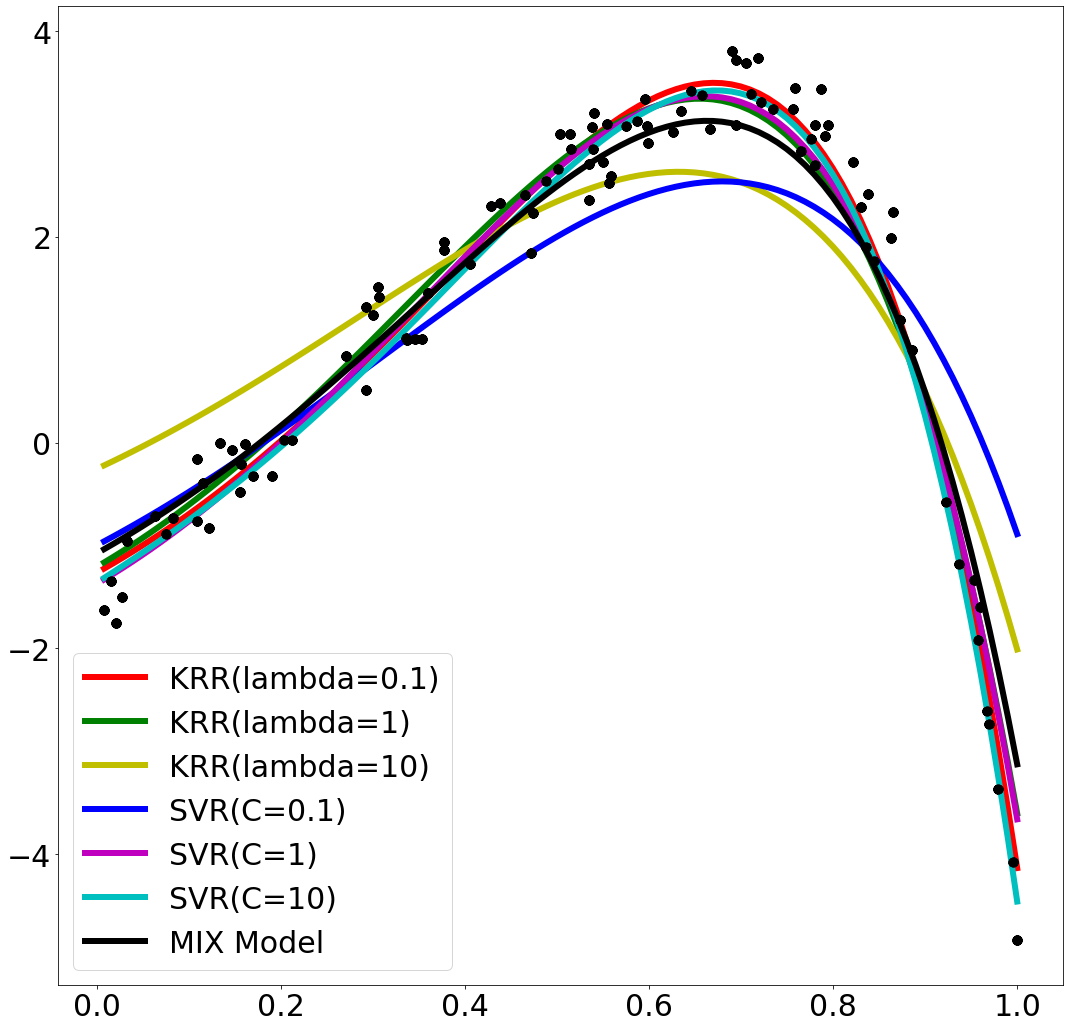

In [11]:
plt.rcParams["figure.figsize"] = (18,18)
PLOT(x,y,a_KRR_1,0,c,gamma,zeta,"KRR(lambda=0.1)","r-")
PLOT(x,y,a_KRR_2,0,c,gamma,zeta,"KRR(lambda=1)","g-")
PLOT(x,y,a_KRR_3,0,c,gamma,zeta,"KRR(lambda=10)","y-")
PLOT(x,y,a_SVR_1,b_SVR_1,c,gamma,zeta,"SVR(C=0.1)","b-")
PLOT(x,y,a_SVR_2,b_SVR_2,c,gamma,zeta,"SVR(C=1)","m-")
PLOT(x,y,a_SVR_3,b_SVR_3,c,gamma,zeta,"SVR(C=10)","c-")
PLOT(x,y,a_MIX,b_MIX,c,gamma,zeta,"MIX Model","k-")
plt.show()